In [1]:
import pathlib

import asdf
import matplotlib
import matplotlib.pyplot as plt
import ndcube
import numpy as np
import astropy.io.fits
import astropy.table
import astropy.units as u
import astropy.wcs
from fiasco.io import Parser
from scipy.interpolate import PchipInterpolator
import sunpy.map
import sunpy.io._fits as sunpy_fits

from sunpy.coordinates import get_earth, Helioprojective
from astropy.coordinates import SkyCoord
from astropy.visualization import quantity_support, ImageNormalize, LogStretch
from astropy.wcs.utils import wcs_to_celestial_frame

from mocksipipeline.util import read_data_cube
from mocksipipeline.instrument.configuration import moxsi_slot
from mocksipipeline.visualization import plot_labeled_spectrum
from overlappy.io import read_overlappogram
from overlappy.util import color_lat_lon_axes

In [2]:
rcparams = {
   'axes.titlesize': 18,
   'axes.labelsize': 18,
   'legend.fontsize': 14,
   'legend.frameon': 'false',
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'xtick.major.pad': 3,
   'xtick.minor.pad': 3,
   'ytick.major.pad': 3,
   'ytick.minor.pad': 3,
   'xtick.direction': 'in',
   'ytick.direction': 'in',
   'savefig.bbox': 'tight',
   'lines.linewidth': 2,
   'patch.linewidth': 2,
}
for k,v in rcparams.items():
    plt.rcParams[k] = v

In [3]:
def add_arrow_from_coords(ax, tail, head, **arrow_kwargs):
    if tail.unit == u.pix:
        transform = 'pixel'
        end_unit = 'pixel'
    else:
        transform = 'world'
        end_unit = 'deg'
    arrow = matplotlib.patches.FancyArrowPatch(tail.to_value(end_unit),
                                               head.to_value(end_unit),
                                               transform=ax.get_transform(transform),
                                               **arrow_kwargs)
    ax.add_patch(arrow)

# TESS 2024 Talk Plots

These are plots of the most up to date MOXSI spectra for Amir's CubIXSS talk at the 2024 TESS meeting

For each, make a full-frame image plot as well as a summed spectra with appropriate line labels

In [4]:
with asdf.open('../data/line_lists/flare-line-table.asdf') as af:
    flare_line_list = af.tree['data']
with asdf.open('../data/line_lists/active-region-line-table.asdf') as af:
    ar_line_list = af.tree['data']

## Active Region

In [5]:
results_root = pathlib.Path('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/tess_amir_talk/')

In [6]:
sort_func = lambda x: int(x.name.split('.')[0].split('_')[-1])
spectrogram_pinhole = [
    read_overlappogram(f) for f in 
    sorted((results_root / 'ar' / 'detector_images').glob('spectrogram_pinhole_*.fits'), key=sort_func)
]
spectrogram_slot = [
    read_overlappogram(f) for f in 
    sorted((results_root / 'ar' / 'detector_images').glob('spectrogram_slot_*.fits'), key=sort_func)
]
sort_func = lambda x: int(x.name.split('.')[0].split('_')[-2])
filtergrams = [
    read_overlappogram(f) for f in 
    sorted((results_root / 'ar' / 'detector_images').glob('filtergram_*.fits'), key=sort_func)
]

In [7]:
full_overlap = read_overlappogram(results_root / 'ar' / 'detector_images' / 'all_components.fits')

Make the image plot

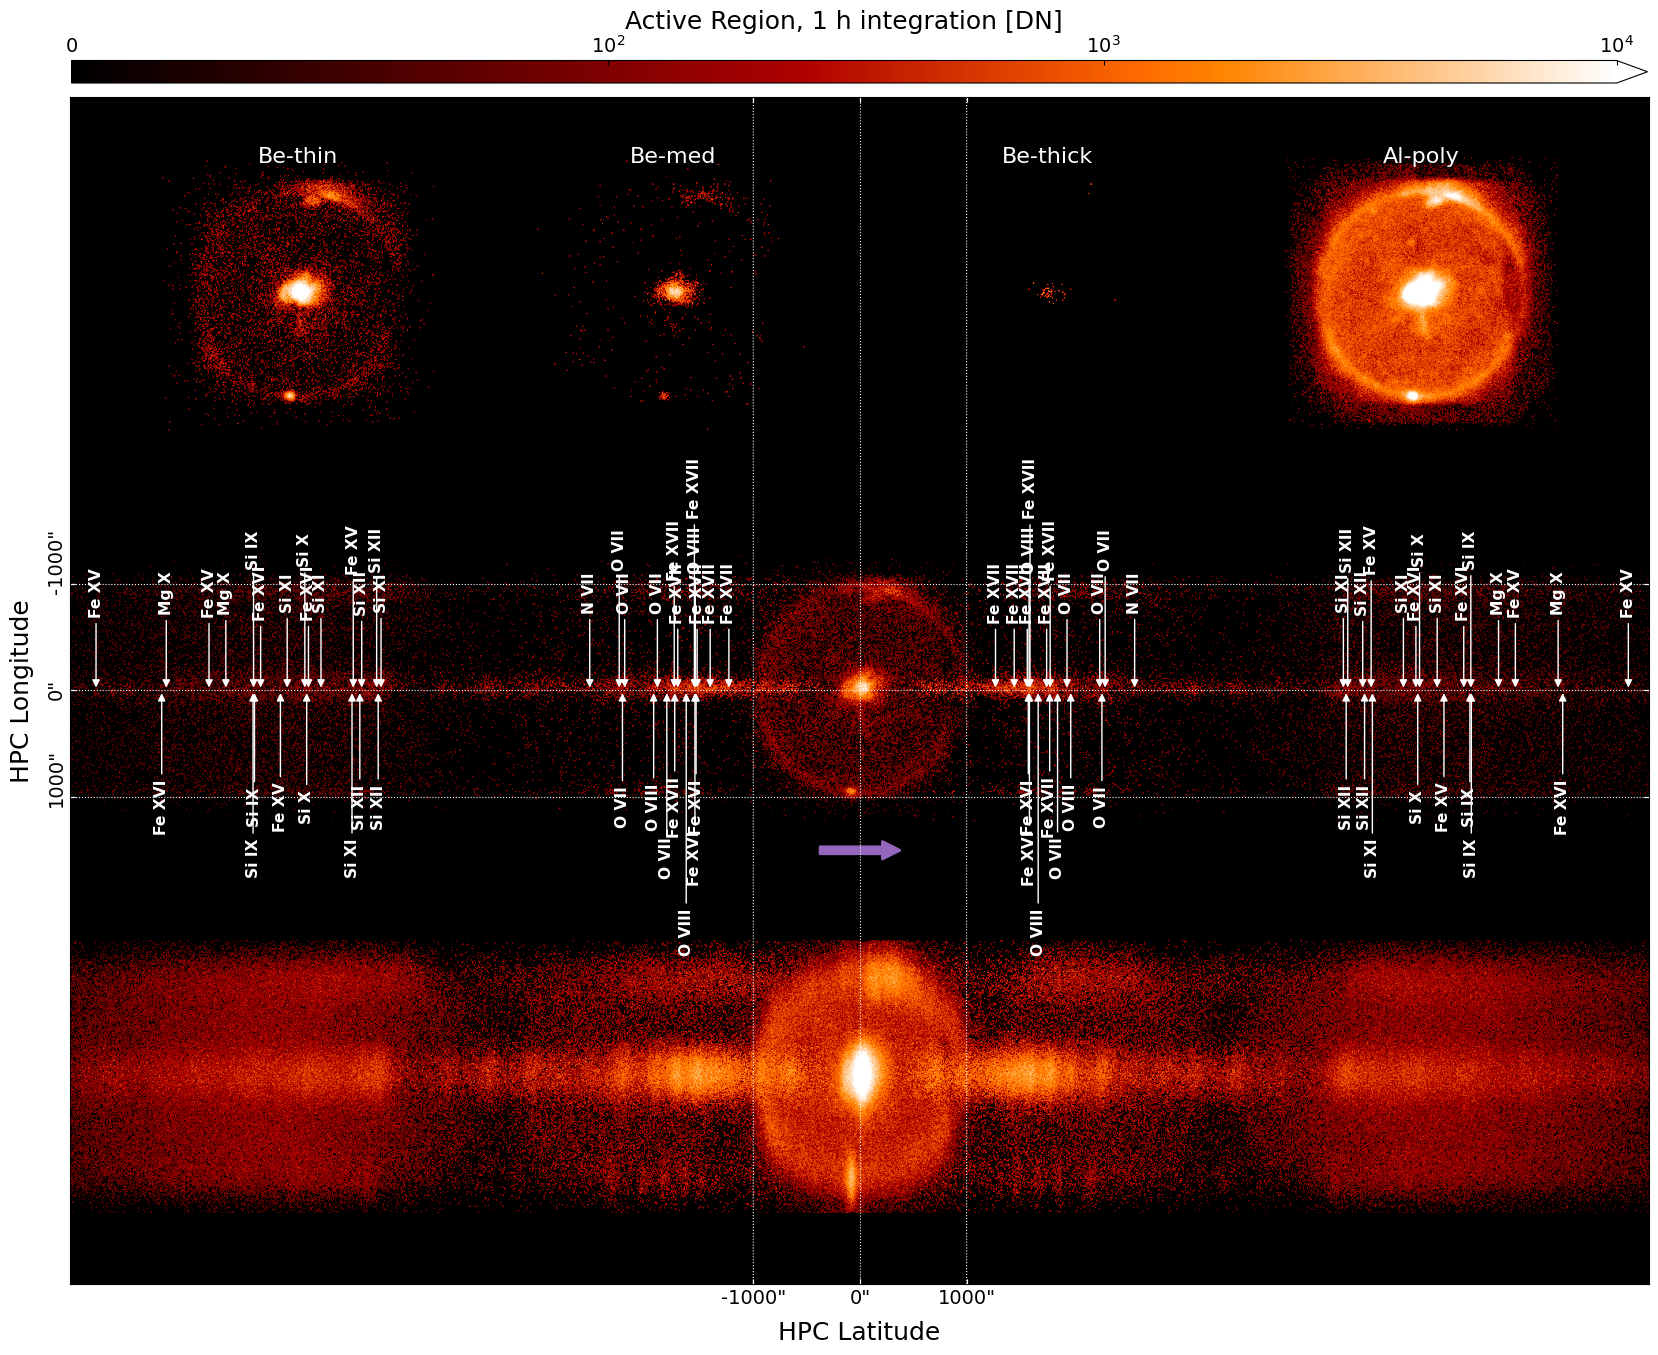

In [40]:
fig = plt.figure(figsize=(20,20*(1504/2000)),layout='tight')
ax = fig.add_subplot(projection=full_overlap[0,...].wcs)
full_overlap[0,...].plot(axes=ax,
                          cmap='hinodexrt',
                          #interpolation='none',
                          norm=ImageNormalize(vmax=1e4,stretch=LogStretch()))

# Ticks and direction annotationes
color_lat_lon_axes(ax, lon_color='w', lat_color='w')
ax.coords[0].set_ticklabel(rotation=90, color='k')
ax.coords[1].set_ticklabel(color='k')
ax.coords[0].grid(ls=':', color='w')
ax.coords[1].grid(ls=':', color='w')
ax.coords[1].set_axislabel('HPC Longitude', color='k')
ax.coords[0].set_axislabel('HPC Latitude', color='k')
for c in ax.coords:
    c.set_ticks(([-1000,0,1000]*u.arcsec).to('deg'))
    c.set_major_formatter('s')

# Add directional arrow
add_arrow_from_coords(ax, (1500, -400)*u.arcsec, (1500, 400)*u.arcsec, color='C4', mutation_scale=25,)

# Add labels to filtergrams
for fg,label in zip(filtergrams,['Be-thin', 'Be-med', 'Be-thick', 'Al-poly']):
    coord = SkyCoord(Tx=-1200*u.arcsec, Ty=0*u.arcsec, frame=wcs_to_celestial_frame(fg.wcs))
    pix_coord = fg[0].wcs.world_to_pixel(coord)
    ax.annotate(label, pix_coord, ha='center', va='bottom', color='w', fontsize=16)


# Add wavelength annotations
annotate_kw = {
    'textcoords': 'offset points',
    'color': 'w',
    'arrowprops': dict(color='w', arrowstyle='-|>', lw=1),
    'horizontalalignment':'center',
    'verticalalignment':'center',
    'rotation':90,
    'fontsize': plt.rcParams['xtick.labelsize']*0.8,
    'weight': 'bold',
}

annot_pt = filtergrams[0][0,...].wcs.array_index_to_world(
    *np.unravel_index(filtergrams[0].data[0].argmax(),
                      filtergrams[0].data[0].shape))
ytext_nom = 70
thresh = 0.05 * u.ph / (u.h * u.pix)
for _wcs in [spectrogram_pinhole[10].wcs, spectrogram_pinhole[12].wcs]:
    ytext = ytext_nom
    pos_previous = 0
    for group in ar_line_list.group_by('MOXSI pixel').groups:
        i_sort = np.argsort(group['active\_region'])
        row = group[i_sort[-1]]
        if row['active\_region'] < thresh:
            continue
        if np.fabs(row['MOXSI pixel'] - pos_previous) < 11:
            ytext *= -1.2
            #if annotate_kw['verticalalignment'] == 'bottom':
        else:
            ytext = ytext_nom
        ax.annotate(
            f'{row["ion name"]}',
            xy=_wcs.world_to_pixel(annot_pt, row['wavelength'])[:2],
            xytext=(0, ytext),
            **annotate_kw
        )
        pos_previous = row['MOXSI pixel']

# colorbar
fig.colorbar(
    ax.get_images()[0],
    ax=ax,
    orientation='horizontal',
    location='top',
    pad=0.01,
    aspect=70,
    extend='max',
    extendfrac=0.02,
    shrink=0.8,
    format=matplotlib.ticker.LogFormatterMathtext(base=10.0,),
    ticks=[0, 100, 1000, 1e4],
    label='Active Region, 1 h integration [DN]')

Make the spectra

Text(0.5, 1.0, 'Active Region slot, 1 h integration')

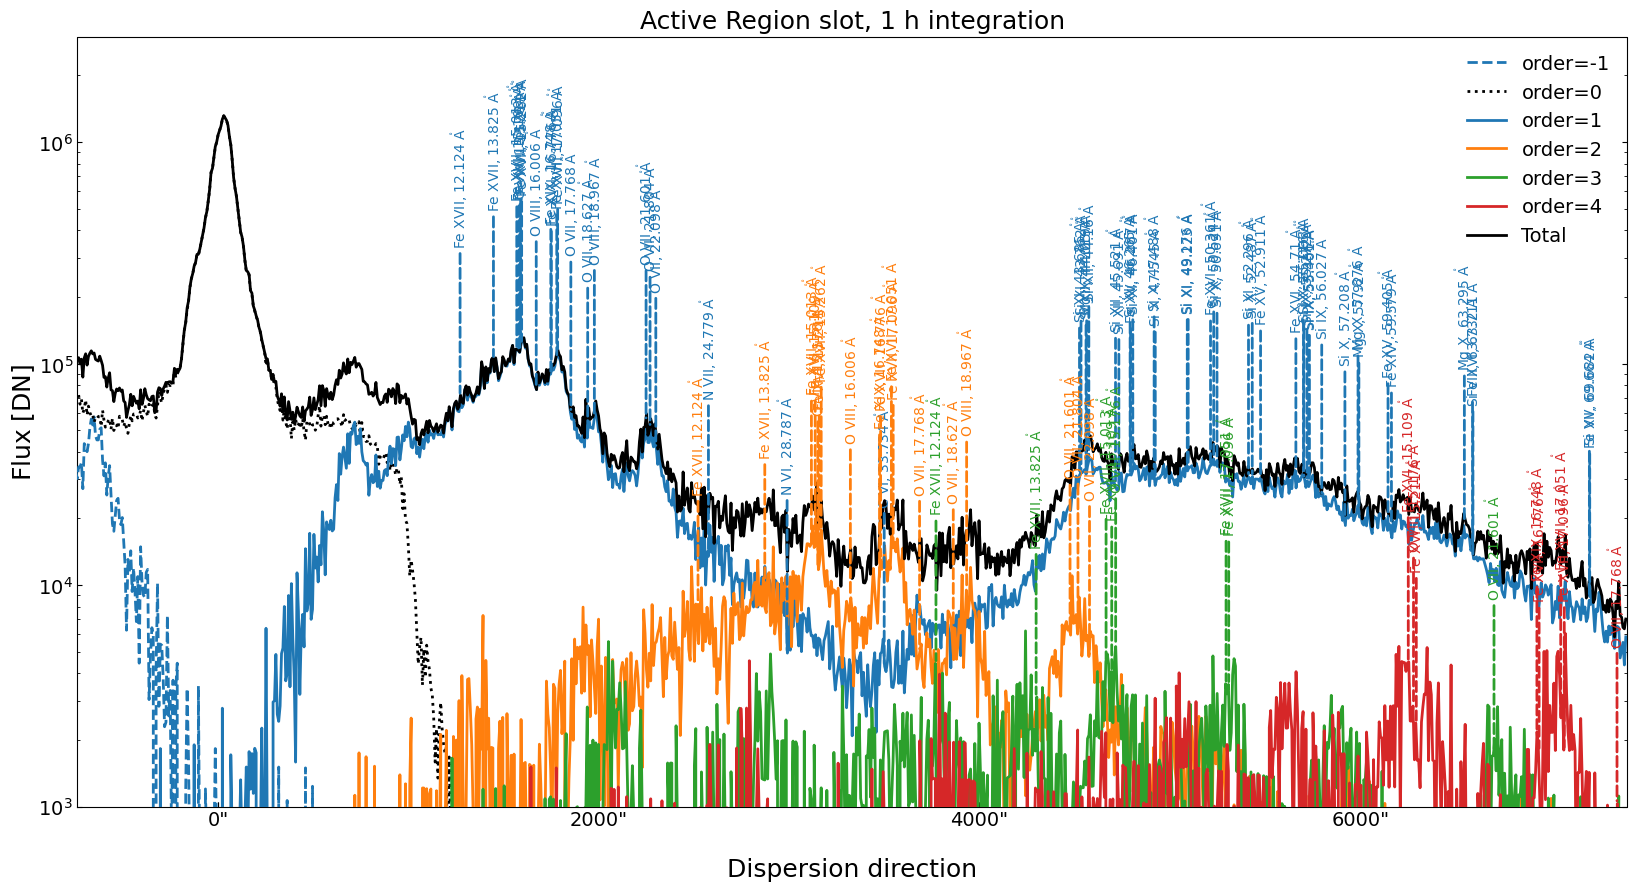

<Figure size 2000x1000 with 0 Axes>

In [45]:
irow,_ = spectrogram_slot[11][0,...].wcs.world_to_array_index(annot_pt)
slot_pixel_width = 110
cutout_slice = np.s_[:,(irow-slot_pixel_width//2):(irow+slot_pixel_width//2),:]
bins_to_sum = cutout_slice[1].stop - cutout_slice[1].start
summed_overlap = full_overlap[cutout_slice].rebin((1,bins_to_sum,1),operation=np.sum)
bins_to_sum = cutout_slice[1].stop - cutout_slice[1].start
summed_overlap = full_overlap[cutout_slice].rebin((1,bins_to_sum,1),operation=np.sum)

components = []
orders = np.arange(-11,12,1)
for order,_component in zip(orders,spectrogram_slot):
    components.append(
        _component[cutout_slice].rebin((1,bins_to_sum,1),operation=np.sum)
    )

fig = plt.figure(figsize=(20,10))
ax = components[10][0,0,:].plot(color='C0', ls='--', label=f'order=-1')
components[11][0,0,:].plot(axes=ax, color='k', ls=':', label=f'order=0')

# Pare down line list
rows = []
for group in ar_line_list.group_by('MOXSI pixel').groups:
    rows.append(group[np.argsort(group['active\_region'])[-1]])
reduced_line_table = astropy.table.QTable(astropy.table.vstack(rows))
reduced_line_table.sort('wavelength')

plot_labeled_spectrum(
    components[12:16],
    summed_overlap,
    reduced_line_table,
    annot_pt,
    threshold=0.1,
    labels=[f'order={order}' for order in orders[12:16]],
    x_lim=(900,2000),
    y_lim=(1000,3e6),
    figure=fig,
    axes=ax,
)

ax.legend(loc=1)

ax.set_title('Active Region slot, 1 h integration')

## Flare

## Active Region

In [50]:
sort_func = lambda x: int(x.name.split('.')[0].split('_')[-1])
spectrogram_pinhole = [
    read_overlappogram(f) for f in 
    sorted((results_root / 'flare' / 'detector_images').glob('spectrogram_pinhole_*.fits'), key=sort_func)
]
spectrogram_slot = [
    read_overlappogram(f) for f in 
    sorted((results_root / 'flare' / 'detector_images').glob('spectrogram_slot_*.fits'), key=sort_func)
]
sort_func = lambda x: int(x.name.split('.')[0].split('_')[-2])
filtergrams = [
    read_overlappogram(f) for f in 
    sorted((results_root / 'flare' / 'detector_images').glob('filtergram_*.fits'), key=sort_func)
]

In [51]:
full_overlap = read_overlappogram(results_root / 'flare' / 'detector_images' / 'all_components.fits')

Make the image plot

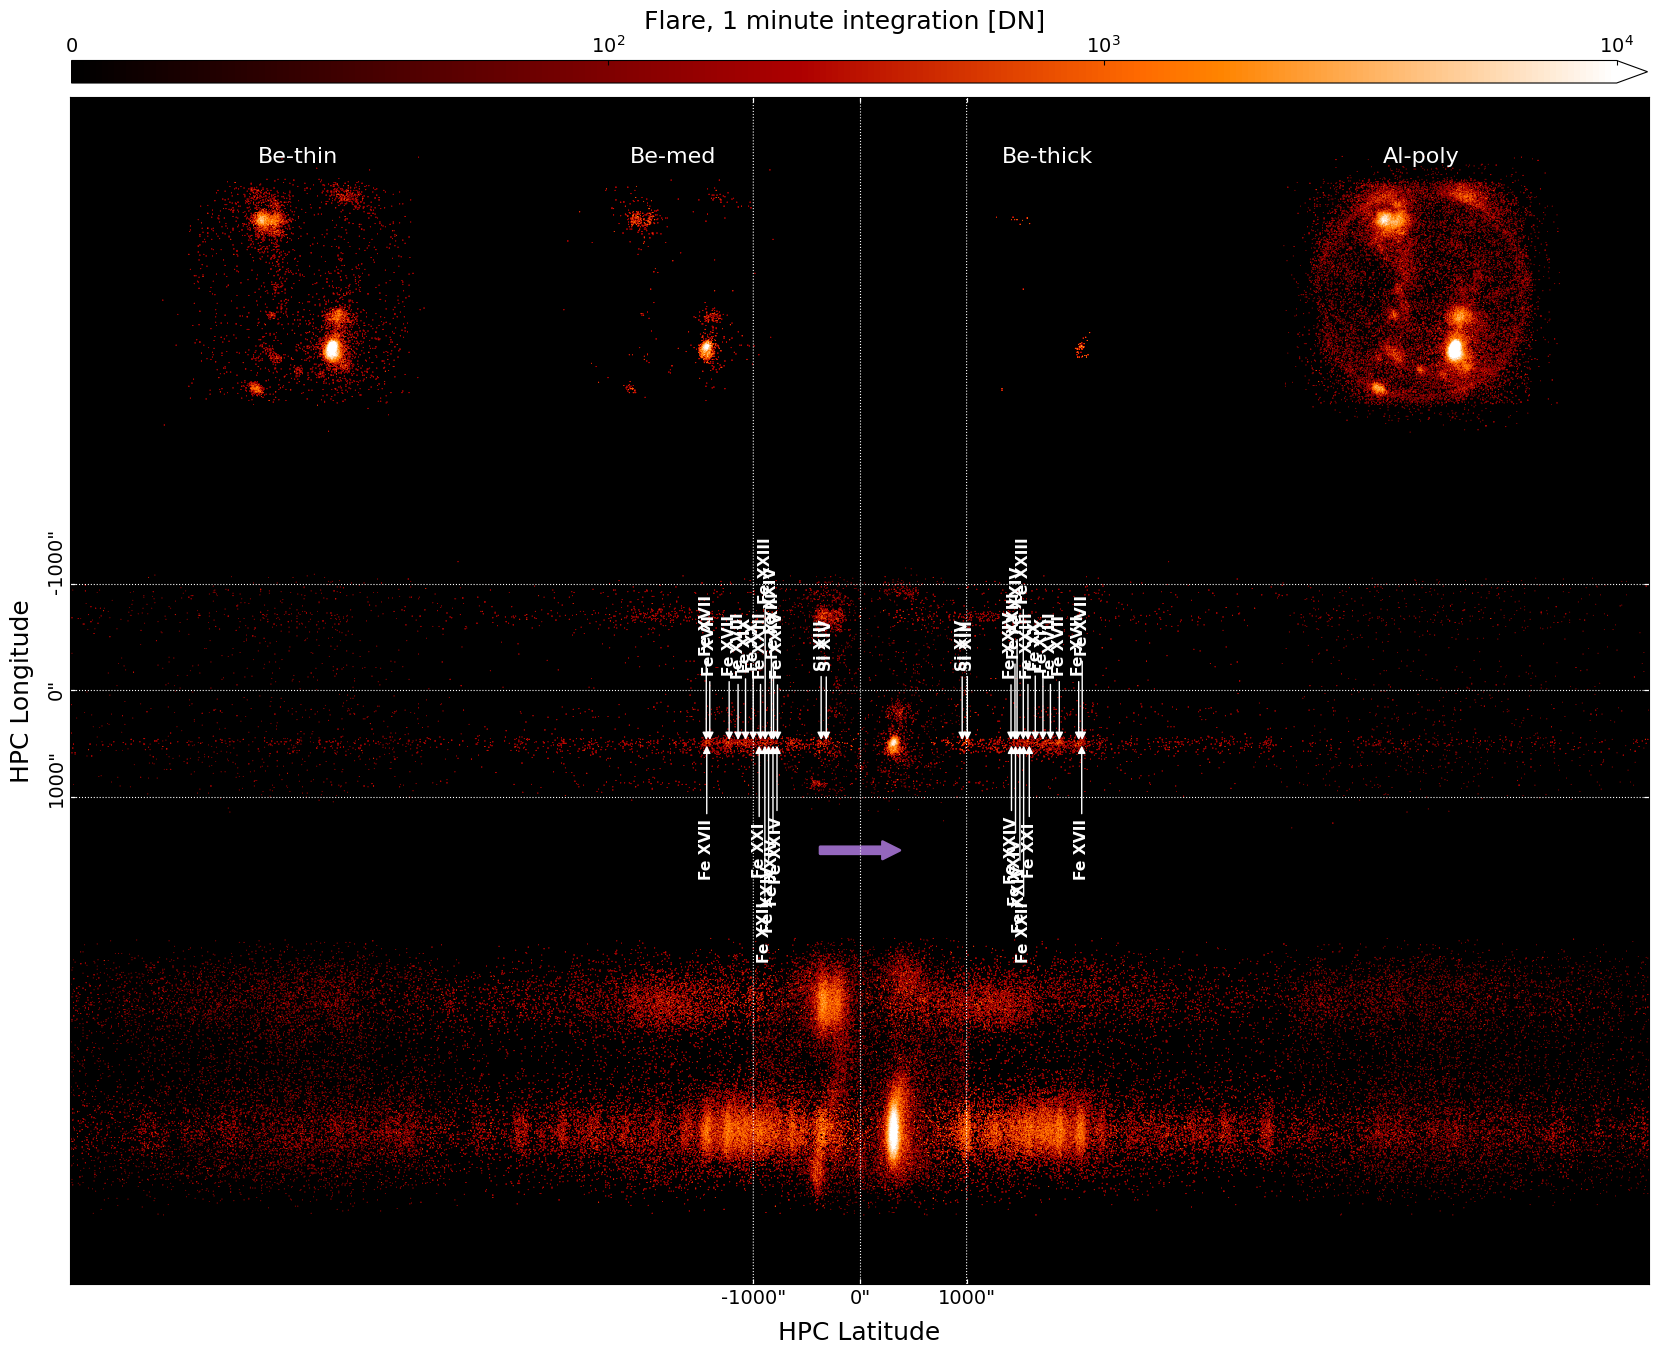

In [82]:
fig = plt.figure(figsize=(20,20*(1504/2000)),layout='tight')
ax = fig.add_subplot(projection=full_overlap[0,...].wcs)
full_overlap[0,...].plot(axes=ax,
                          cmap='hinodexrt',
                          #interpolation='none',
                          norm=ImageNormalize(vmax=1e4,stretch=LogStretch()))

# Ticks and direction annotationes
color_lat_lon_axes(ax, lon_color='w', lat_color='w')
ax.coords[0].set_ticklabel(rotation=90, color='k')
ax.coords[1].set_ticklabel(color='k')
ax.coords[0].grid(ls=':', color='w')
ax.coords[1].grid(ls=':', color='w')
ax.coords[1].set_axislabel('HPC Longitude', color='k')
ax.coords[0].set_axislabel('HPC Latitude', color='k')
for c in ax.coords:
    c.set_ticks(([-1000,0,1000]*u.arcsec).to('deg'))
    c.set_major_formatter('s')

# Add directional arrow
add_arrow_from_coords(ax, (1500, -400)*u.arcsec, (1500, 400)*u.arcsec, color='C4', mutation_scale=25,)

# Add labels to filtergrams
for fg,label in zip(filtergrams,['Be-thin', 'Be-med', 'Be-thick', 'Al-poly']):
    coord = SkyCoord(Tx=-1200*u.arcsec, Ty=0*u.arcsec, frame=wcs_to_celestial_frame(fg.wcs))
    pix_coord = fg[0].wcs.world_to_pixel(coord)
    ax.annotate(label, pix_coord, ha='center', va='bottom', color='w', fontsize=16)


# Add wavelength annotations
annotate_kw = {
    'textcoords': 'offset points',
    'color': 'w',
    'arrowprops': dict(color='w', arrowstyle='-|>', lw=1),
    'horizontalalignment':'center',
    'verticalalignment':'center',
    'rotation':90,
    'fontsize': plt.rcParams['xtick.labelsize']*0.8,
    'weight': 'bold',
}

annot_pt = filtergrams[0][0,...].wcs.array_index_to_world(
    *np.unravel_index(filtergrams[0].data[0].argmax(),
                      filtergrams[0].data[0].shape))
ytext_nom = 70
thresh = 0.5 * u.ph / (u.s * u.pix)
for _wcs in [spectrogram_pinhole[10].wcs, spectrogram_pinhole[12].wcs]:
    ytext = ytext_nom
    pos_previous = 0
    for group in flare_line_list.group_by('MOXSI pixel').groups:
        i_sort = np.argsort(group['flare\_ext'])
        row = group[i_sort[-1]]
        if row['flare\_ext'] < thresh:
            continue
        if np.fabs(row['MOXSI pixel'] - pos_previous) < 5:
            ytext *= -1.1
            #if annotate_kw['verticalalignment'] == 'bottom':
        else:
            ytext = ytext_nom
        ax.annotate(
            f'{row["ion name"]}',
            xy=_wcs.world_to_pixel(annot_pt, row['wavelength'])[:2],
            xytext=(0, ytext),
            **annotate_kw
        )
        pos_previous = row['MOXSI pixel']

# colorbar
fig.colorbar(
    ax.get_images()[0],
    ax=ax,
    orientation='horizontal',
    location='top',
    pad=0.01,
    aspect=70,
    extend='max',
    extendfrac=0.02,
    shrink=0.8,
    format=matplotlib.ticker.LogFormatterMathtext(base=10.0,),
    ticks=[0, 100, 1000, 1e4],
    label='Flare, 1 minute integration [DN]')

Make the spectra

/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data
/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/visualization.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = cube.data / cube_total.data


Text(0.5, 1.0, 'Flare slot, 1 minute integration')

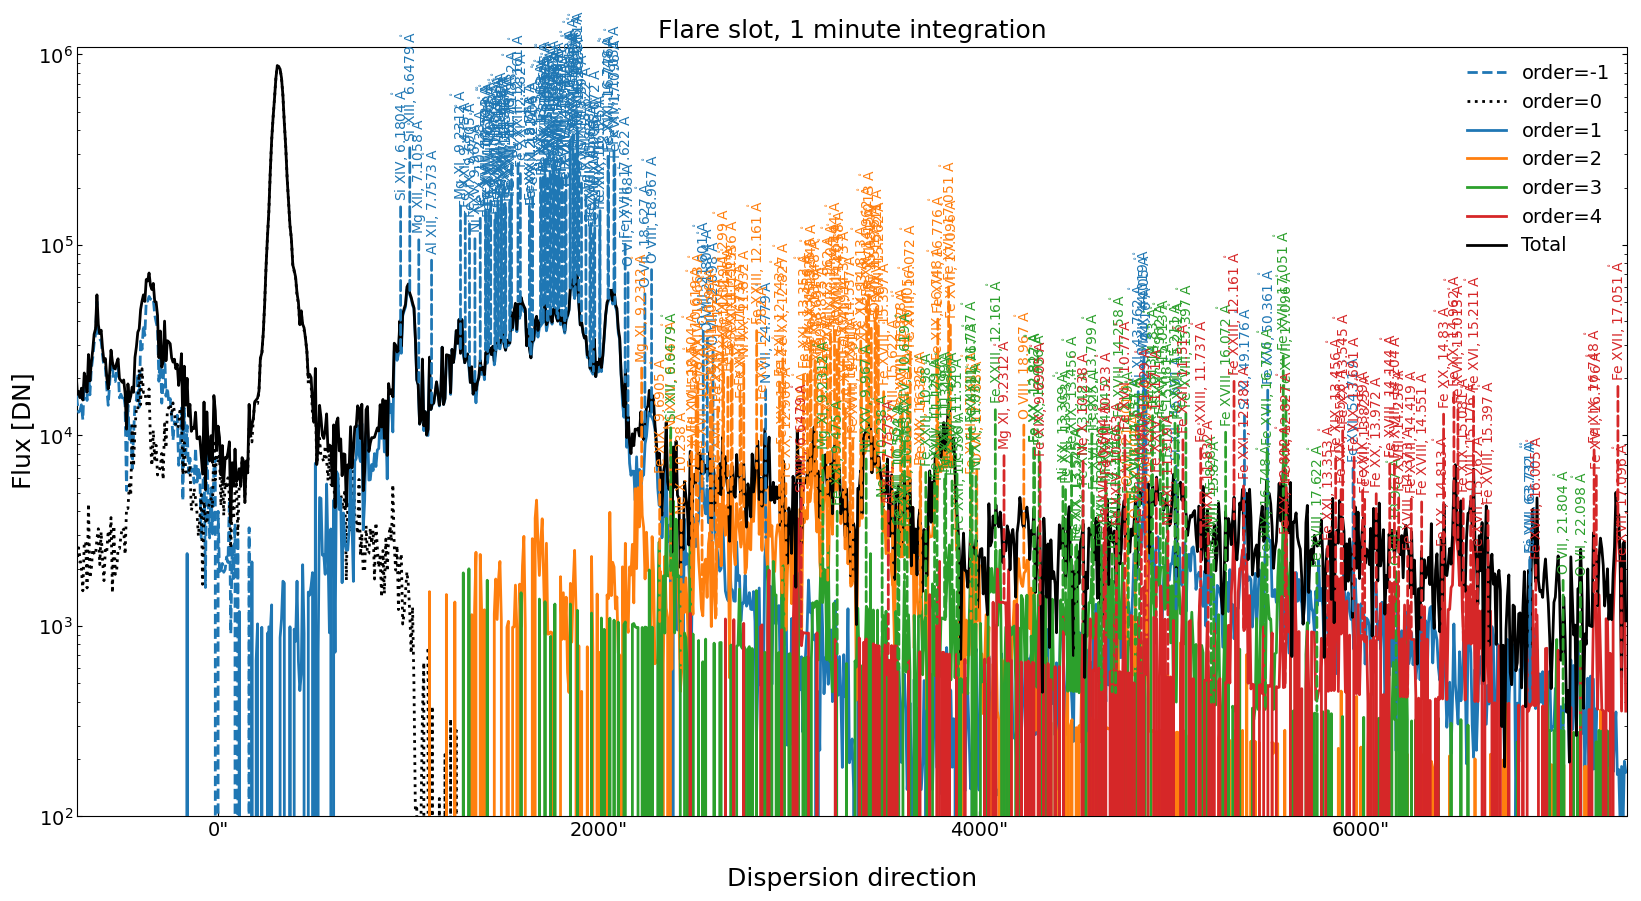

<Figure size 2000x1000 with 0 Axes>

In [85]:
irow,_ = spectrogram_slot[11][0,...].wcs.world_to_array_index(annot_pt)
slot_pixel_width = 110
cutout_slice = np.s_[:,(irow-slot_pixel_width//2):(irow+slot_pixel_width//2),:]
bins_to_sum = cutout_slice[1].stop - cutout_slice[1].start
summed_overlap = full_overlap[cutout_slice].rebin((1,bins_to_sum,1),operation=np.sum)

components = []
orders = np.arange(-11,12,1)
for order,_component in zip(orders,spectrogram_slot):
    components.append(
        _component[cutout_slice].rebin((1,bins_to_sum,1),operation=np.sum)
    )

fig = plt.figure(figsize=(20,10))
ax = components[10][0,0,:].plot(color='C0', ls='--', label=f'order=-1')
components[11][0,0,:].plot(axes=ax, color='k', ls=':', label=f'order=0')

# Pare down line list
rows = []
for group in flare_line_list.group_by('MOXSI pixel').groups:
    rows.append(group[np.argsort(group['flare\_ext'])[-1]])
reduced_line_table = astropy.table.QTable(astropy.table.vstack(rows))
reduced_line_table.sort('wavelength')

plot_labeled_spectrum(
    components[12:16],
    summed_overlap,
    reduced_line_table,
    annot_pt,
    threshold=0.1,
    labels=[f'order={order}' for order in orders[12:16]],
    x_lim=(900,2000),
    y_lim=(100,1.1e6),
    figure=fig,
    axes=ax,
)

ax.legend(loc=1)

ax.set_title('Flare slot, 1 minute integration')